Kütüphaneler

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset, DataLoader)
from skimage import io 
import time 
import warnings as w
w.filterwarnings("ignore")


Veri 

In [103]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return(image, y_label)


Veri Hazırlama

In [104]:

dataset = veri(csv_file=r"../../veriler/f1_classification/f111.csv", root_dir=r"../../veriler/f1_classification", transform=transforms.Compose([

    transforms.ToTensor(),
    transforms.Resize(size=(64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))


Veri Önişleme

In [105]:
train_set, test_set = torch.utils.data.random_split(dataset, [200, 79])
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=1, shuffle=True)

Veri Görselleştirme

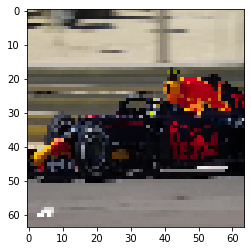

Redbull
torch.Size([1, 3, 64, 64])


In [106]:
import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
classes = ["Ferrari", "Mclaren", "Mercedes", "Redbull"]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print(images.size())

Model Eğitimi

In [109]:
start = time.time()
print("Transfer Learning Eğitimi Başlıyor")
print("----------------------------------")

import torchvision.models as models
model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(2208,2048),
    nn.ReLU(inplace=True),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,512),
    nn.ReLU(inplace=True),
    nn.Linear(512,256),
    nn.ReLU(inplace=True),
    nn.Linear(256,64),
    nn.ReLU(inplace=True),
    nn.Linear(64,16),
    nn.ReLU(inplace=True),
    nn.Linear(16,4)
)   

error = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01)

epoch=3
count = 0
iterasyon = []


for i in range(epoch):
    for j, (images, label) in enumerate(train_loader):
        out = model(images)
        loss = error(out, label) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count += 1

        if count % 20 == 0:
            iterasyon.append(count)

            print("iterasyon:{:4}--loss:{:.4f}".format(count, loss.item()))


print("Transfer Learning Eğitimi Bitti")
print("----------------------------------")
end = time.time()
print("Süre:", end-start)

Transfer Learning Eğitimi Başlıyor
----------------------------------
iterasyon:  20--loss:1.6093
iterasyon:  40--loss:1.2801
iterasyon:  60--loss:1.4210
iterasyon:  80--loss:1.2107
iterasyon: 100--loss:1.3289
iterasyon: 120--loss:1.3216
iterasyon: 140--loss:1.3244
iterasyon: 160--loss:1.3881
iterasyon: 180--loss:1.4012
iterasyon: 200--loss:1.4706
iterasyon: 220--loss:1.4252
iterasyon: 240--loss:1.3676
iterasyon: 260--loss:1.5138
iterasyon: 280--loss:1.4970
iterasyon: 300--loss:1.3194
iterasyon: 320--loss:1.3795
iterasyon: 340--loss:1.3756
iterasyon: 360--loss:1.3825
iterasyon: 380--loss:1.3516
iterasyon: 400--loss:1.3127
iterasyon: 420--loss:1.2755
iterasyon: 440--loss:1.5698
iterasyon: 460--loss:1.5436
iterasyon: 480--loss:1.3766
iterasyon: 500--loss:1.4198
iterasyon: 520--loss:1.4958
iterasyon: 540--loss:1.2824
iterasyon: 560--loss:1.4149
iterasyon: 580--loss:1.3851
iterasyon: 600--loss:1.3166
Transfer Learning Eğitimi Bitti
----------------------------------
Süre: 102.4664490222930

Model Testi

In [111]:
def dogruluk(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    device=torch.device("cuda")
    model = model.to(device)

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x.float())
            _, pred = out.max(1)
            num_correct += (pred == y).sum()
            num_samples += pred.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")
        model.train()


In [112]:
print("train doğruluk:")
dogruluk(train_loader, model)

print("test doğruluk:")
dogruluk(test_loader, model)

train doğruluk:
Got 56 / 200 with accuracy 28.00
test doğruluk:
Got 13 / 79 with accuracy 16.46
